<a href="https://colab.research.google.com/github/Rimahbo/analysis-and-preaching/blob/main/analyse_et_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation de bibliothèques nécessaires**

In [ ]:
!pip install pyspark matplotlib seaborn pandas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assurez-vous que Spark et pandas sont correctement configurés
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

**Initialisation de la session Spark**

In [ ]:
#cette ligne permet de créer ou d'obtenir une session Spark pour effectuer des traitements distribués sur de BigData
spark = SparkSession.builder \
    .appName("Patient Data Analysis") \
    .getOrCreate()

**Téléchargement  des données CSV dans un DataFrame PySpark**

In [ ]:
from google.colab import files
uploaded = files.upload()

# Charger le fichier CSV dans un DataFrame PySpark
file_path = list(uploaded.keys())[0]  # Récupère le nom du fichier téléchargé
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=";")


Saving PatientsData.csv to PatientsData.csv


** Nettoyage des données**

In [ ]:
df = df.dropna()

**Renommage des colonnes du DataFrame PySpark**

In [ ]:
columns_mapping = {
    "SmokerStatus": "Smoking",
    "HadHeartAttack": "HeartDisease",
    "GeneralHealth": "HealthStatus",
    "BMI": "BodyMassIndex",
}
for old_col, new_col in columns_mapping.items():
    if old_col in df.columns:
        df = df.withColumnRenamed(old_col, new_col)

# **Analyse de la Distribution des Patients**

### **par sexe**

Distribution des patients par sexe (tableau) :


,Sex,count
0,Female,123293
1,Male,114337


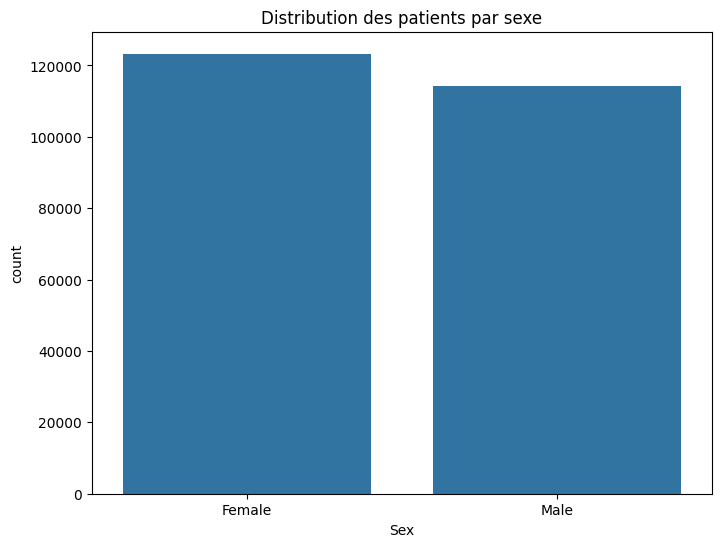

In [ ]:
# Exemple 1 : Distribution des patients par sexe
if "Sex" in df.columns:
    sex_distribution = df.groupBy("Sex").count().toPandas()  # Convertir en DataFrame Pandas pour visualisation
    # Affichage sous forme de tableau
    print("Distribution des patients par sexe (tableau) :")
    display(sex_distribution)  # Utilisation de display() pour afficher un tableau bien formaté dans Colab
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Sex', y='count', data=sex_distribution)
    plt.title('Distribution des patients par sexe')
    plt.show()

## **par HealthStatus**

IMC moyen par condition de santé (tableau) :


,HealthStatus,IMC_Moyen
0,Excellent,28.534060
1,Good,31.078546
2,Fair,32.406667
3,Very good,29.892900
4,Poor,33.886598


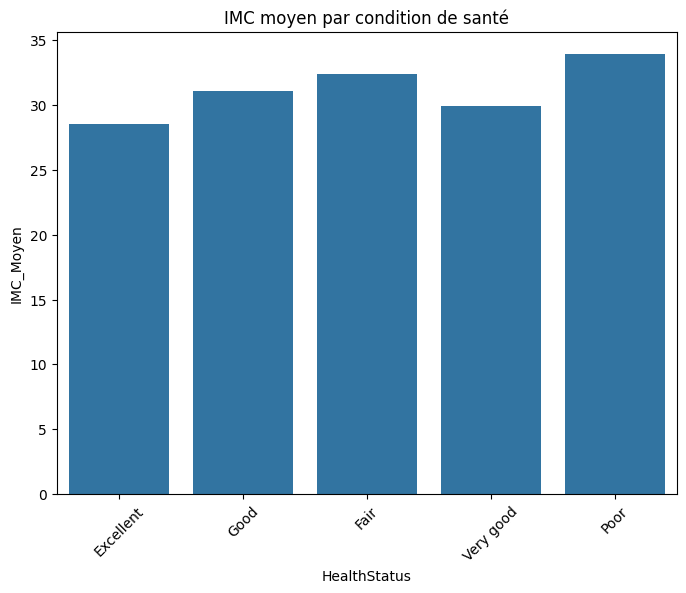

In [ ]:
# Exemple 2 : IMC moyen par condition de santé
if "HealthStatus" in df.columns and "BodyMassIndex" in df.columns:
    imc_moyen = df.groupBy("HealthStatus").agg(avg("BodyMassIndex").alias("IMC_Moyen")).toPandas()
    # Affichage sous forme de tableau
    print("IMC moyen par condition de santé (tableau) :")
    display(imc_moyen)  # Affichage en format tableau dans Colab
    plt.figure(figsize=(8, 6))
    sns.barplot(x='HealthStatus', y='IMC_Moyen', data=imc_moyen)
    plt.title('IMC moyen par condition de santé')
    plt.xticks(rotation=45)
    plt.show()

## **par Smoking**

Répartition des maladies cardiaques chez les fumeurs : Never smoked (tableau) :


,HeartDisease,count
0,1,5378
1,0,137012


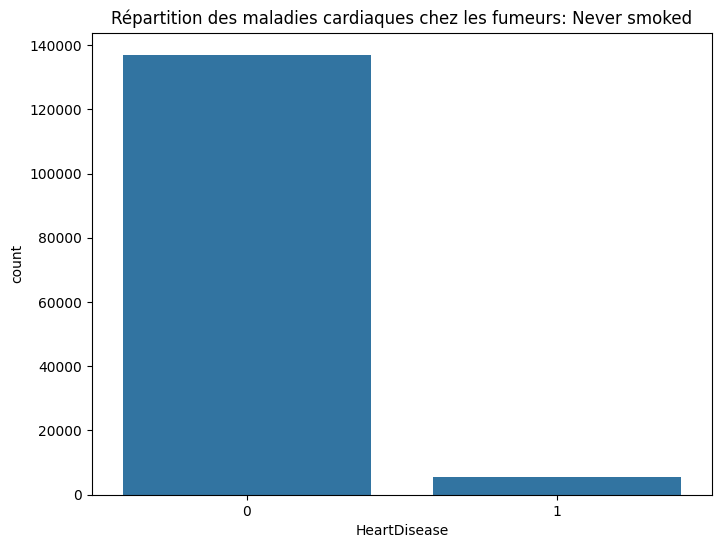

Répartition des maladies cardiaques chez les fumeurs : Former smoker (tableau) :


,HeartDisease,count
0,1,5495
1,0,60698


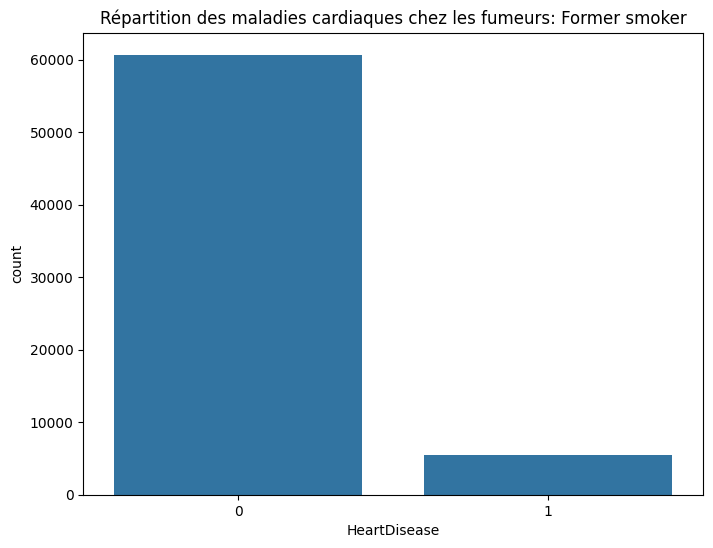

Répartition des maladies cardiaques chez les fumeurs : Current smoker - now smokes every day (tableau) :


,HeartDisease,count
0,1,1776
1,0,19372


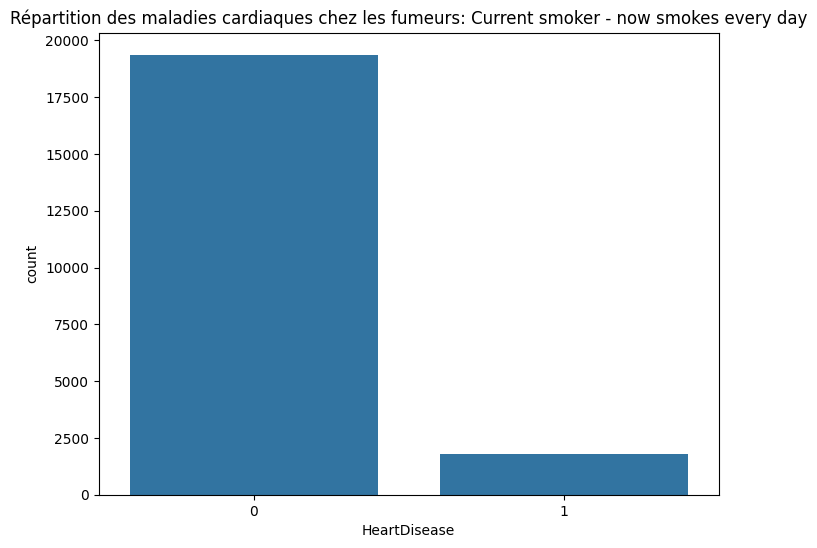

In [ ]:
if "Smoking" in df.columns and "HeartDisease" in df.columns:
    smoking_statuses = ["Never smoked", "Former smoker", "Current smoker - now smokes every day"]
    for status in smoking_statuses:
        smoking_data = df.filter(col("Smoking") == status).groupBy("HeartDisease").count().toPandas()
        # Affichage sous forme de tableau
        print(f"Répartition des maladies cardiaques chez les fumeurs : {status} (tableau) :")
        display(smoking_data)  # Affichage en format tableau dans Colab
        plt.figure(figsize=(8, 6))
        sns.barplot(x='HeartDisease', y='count', data=smoking_data)
        plt.title(f'Répartition des maladies cardiaques chez les fumeurs: {status}')
        plt.show()


# ** Analyse et Modélisation des Données Patients : **

## **Prédiction de la Hauteur et du Poids en Fonction de l'Âge**

Évaluation pour la hauteur :
R2 Score : 0.01399702969456773
Erreur quadratique moyenne : 0.011313512609425931

Évaluation pour le poids :
R2 Score : 0.006299578162688779
Erreur quadratique moyenne : 451.3673068174639



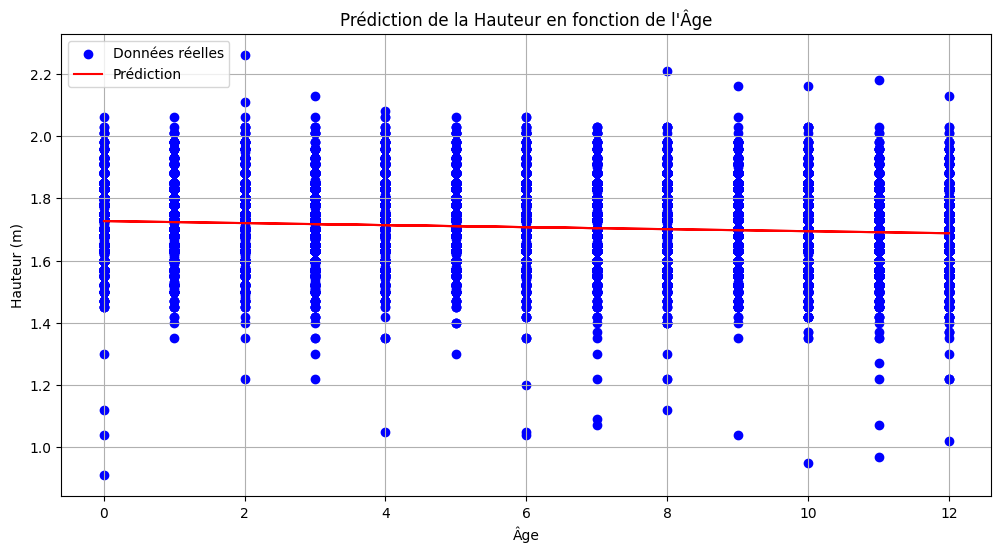

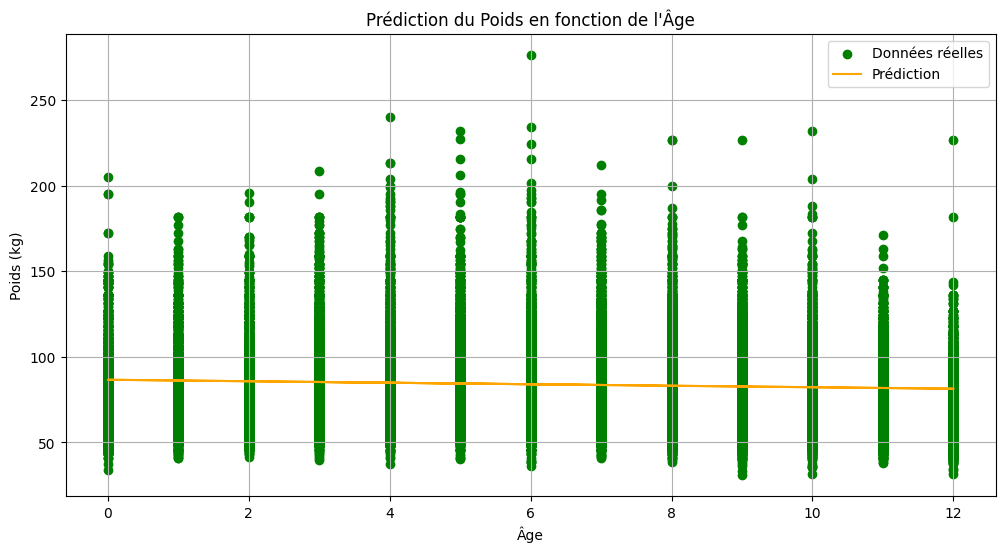

Prédictions pour de nouveaux âges :
   Age  Predicted_HeightInMeters  Predicted_WeightInKilograms
0   20                  1.661770                    77.886157
1   30                  1.629198                    73.517877
2   40                  1.596626                    69.149596
3   50                  1.564054                    64.781316
Les prédictions ont été enregistrées dans 'predictions.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.preprocessing import LabelEncoder

# Créez ou utilisez votre session Spark
spark = SparkSession.builder.appName("BMI Analysis").getOrCreate()

# Charger les données depuis un fichier CSV avec PySpark
file_path = "PatientsData.csv"  # Remplacez par le chemin de votre fichier
data = spark.read.csv(file_path, header=True, inferSchema=True, sep=";")

# Vérifier les colonnes nécessaires
if "AgeCategory" not in data.columns or "HeightInMeters" not in data.columns or "WeightInKilograms" not in data.columns:
    raise ValueError("Le fichier doit contenir les colonnes 'AgeCategory', 'HeightInMeters' et 'WeightInKilograms'.")

# Sélectionner les colonnes du DataFrame PySpark
X = data.select("AgeCategory")  # Variable indépendante
y_height = data.select("HeightInMeters")  # Variable dépendante pour la hauteur
y_weight = data.select("WeightInKilograms")  # Variable dépendante pour le poids

# Convertir le DataFrame PySpark en DataFrame Pandas
X_pandas = X.toPandas()
y_height_pandas = y_height.toPandas()
y_weight_pandas = y_weight.toPandas()

# Encoder la variable 'AgeCategory' en valeurs numériques
label_encoder = LabelEncoder()
X_pandas["AgeCategory"] = label_encoder.fit_transform(X_pandas["AgeCategory"])

# Convertir les colonnes de hauteur et de poids en type float en remplaçant la virgule par un point
y_height_pandas = y_height_pandas.replace({',': '.'}, regex=True).astype(float)
y_weight_pandas = y_weight_pandas.replace({',': '.'}, regex=True).astype(float)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_height_train, y_height_test = train_test_split(X_pandas, y_height_pandas, test_size=0.2, random_state=42)
_, _, y_weight_train, y_weight_test = train_test_split(X_pandas, y_weight_pandas, test_size=0.2, random_state=42)

# Modèles de régression linéaire pour la hauteur et le poids
model_height = LinearRegression()
model_weight = LinearRegression()

# Entraîner les modèles
model_height.fit(X_train, y_height_train)
model_weight.fit(X_train, y_weight_train)

# Prédictions
y_height_pred = model_height.predict(X_test)
y_weight_pred = model_weight.predict(X_test)

# Évaluer les modèles
print("Évaluation pour la hauteur :")
print(f"R2 Score : {r2_score(y_height_test, y_height_pred)}")
print(f"Erreur quadratique moyenne : {mean_squared_error(y_height_test, y_height_pred)}\n")

print("Évaluation pour le poids :")
print(f"R2 Score : {r2_score(y_weight_test, y_weight_pred)}")
print(f"Erreur quadratique moyenne : {mean_squared_error(y_weight_test, y_weight_pred)}\n")

# Visualisation : Prédiction de la hauteur en fonction de l'âge
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_height_test, color='blue', label='Données réelles')
plt.plot(X_test, y_height_pred, color='red', label='Prédiction')
plt.title('Prédiction de la Hauteur en fonction de l\'Âge')
plt.xlabel('Âge')
plt.ylabel('Hauteur (m)')
plt.legend()
plt.grid()
plt.show()

# Visualisation : Prédiction du poids en fonction de l'âge
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_weight_test, color='green', label='Données réelles')
plt.plot(X_test, y_weight_pred, color='orange', label='Prédiction')
plt.title('Prédiction du Poids en fonction de l\'Âge')
plt.xlabel('Âge')
plt.ylabel('Poids (kg)')
plt.legend()
plt.grid()
plt.show()

# Faire des prédictions pour de nouveaux âges
new_ages = np.array([20, 30, 40, 50]).reshape(-1, 1)  # Exemple d'âges pour prédiction
predicted_heights = model_height.predict(new_ages)
predicted_weights = model_weight.predict(new_ages)


# Afficher les prédictions
predictions = pd.DataFrame({
    "Age": new_ages.flatten(),  # aplatir le tableau
    "Predicted_HeightInMeters": predicted_heights.flatten(),  # aplatir le tableau
    "Predicted_WeightInKilograms": predicted_weights.flatten()  # aplatir le tableau
})
print("Prédictions pour de nouveaux âges :")
print(predictions)

# Sauvegarder les prédictions dans un fichier CSV
predictions.to_csv("predictions.csv", index=False)
print("Les prédictions ont été enregistrées dans 'predictions.csv'.")


# **Prédiction de la Réalisation de Tests COVID-19 Basée sur le Nombre de Tests VIH : **

## **Modélisation avec Régression Logistique**

Précision du modèle : 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


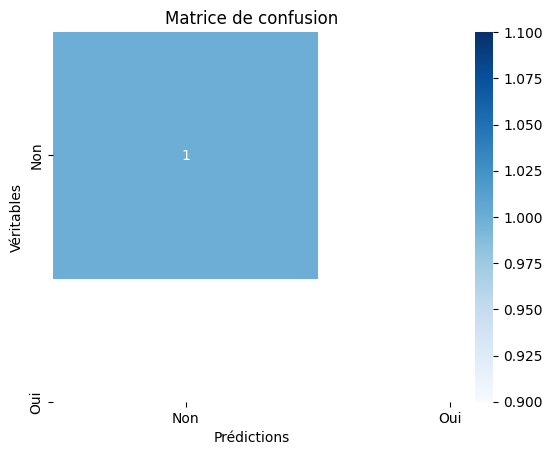

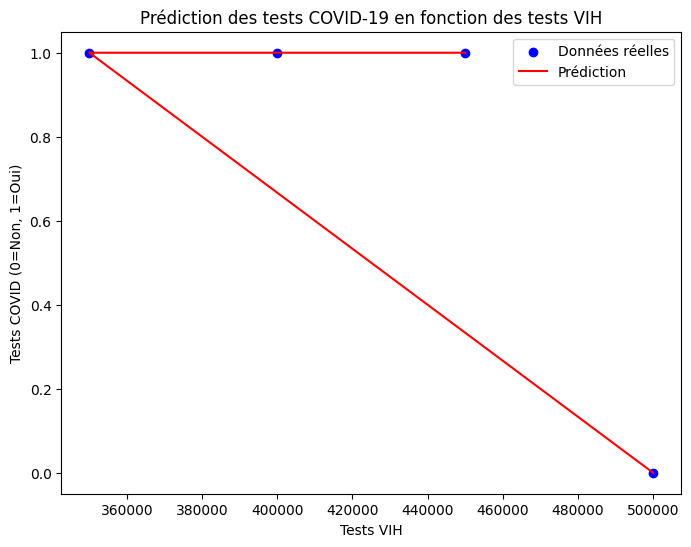

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Exemple de données
# Supposons que nous avons les années, les tests VIH effectués et si un test COVID a été effectué (0 ou 1)
data = {
    "Year": [2019, 2020, 2021, 2022],
    "HIV_Tests_Conducted": [500000, 350000, 400000, 450000],  # Nombre de tests VIH réalisés
    "COVID_Tested": [0, 1, 1, 1]  # 0 = Aucun test COVID, 1 = Test COVID effectué
}

# Créer un DataFrame Pandas
df = pd.DataFrame(data)

# Caractéristiques (variables indépendantes)
X = df[["HIV_Tests_Conducted"]]  # Nous allons utiliser le nombre de tests VIH effectués pour prédire la probabilité d'un test COVID

# Variable cible (si un test COVID a été effectué)
y = df["COVID_Tested"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()

# Visualisation des prédictions
plt.figure(figsize=(8, 6))
plt.scatter(df["HIV_Tests_Conducted"], df["COVID_Tested"], color="blue", label="Données réelles")
plt.plot(df["HIV_Tests_Conducted"], model.predict(df[["HIV_Tests_Conducted"]]), color="red", label="Prédiction")
plt.title("Prédiction des tests COVID-19 en fonction des tests VIH")
plt.xlabel("Tests VIH")
plt.ylabel("Tests COVID (0=Non, 1=Oui)")
plt.legend()
plt.show()

# **Analyse et Prédiction des Difficultés à Marcher en Fonction de l'Arthrite et de l'Âge : **

## **Approche par Régression Logistique**

Précision du modèle : 1.00


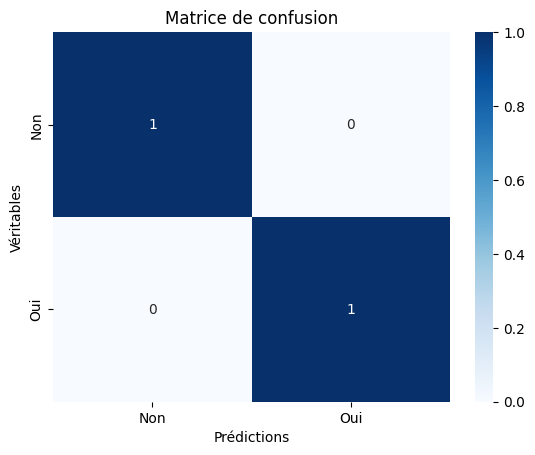

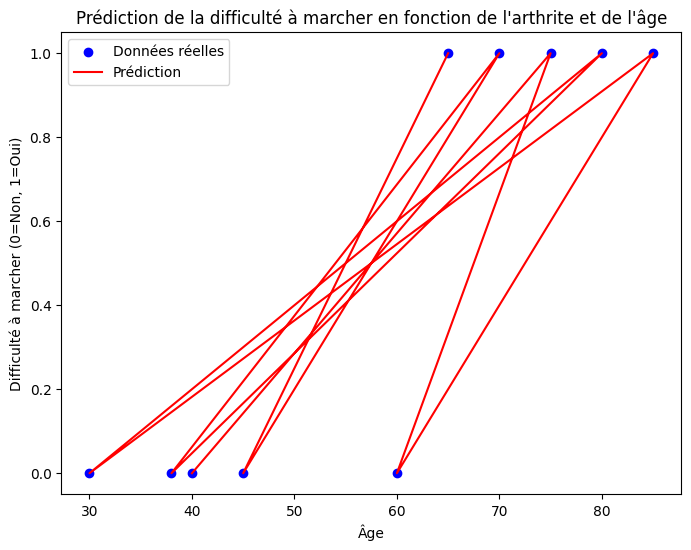

In [ ]:


# Exemple de données (remplacez-les par vos données réelles)
data = {
    "Arthritis": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # 1 = Aucune arthrite, 0 = Avec arthrite
    "Age": [65, 45, 70, 38, 80, 30, 85, 60, 75, 40],  # Âge des patients
    "DifficultyWalking": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1 = Difficulté à marcher, 0 = Pas de difficulté
}

# Créer un DataFrame Pandas
df = pd.DataFrame(data)

# Caractéristiques (variables indépendantes)
X = df[["Arthritis", "Age"]]  # Utilisation de l'arthrite et de l'âge pour prédire la difficulté à marcher

# Variable cible (si la personne a des difficultés à marcher)
y = df["DifficultyWalking"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()

# Visualisation des prédictions
plt.figure(figsize=(8, 6))
plt.scatter(df["Age"], df["DifficultyWalking"], color="blue", label="Données réelles")
plt.plot(df["Age"], model.predict(df[["Arthritis", "Age"]]), color="red", label="Prédiction")
plt.title("Prédiction de la difficulté à marcher en fonction de l'arthrite et de l'âge")
plt.xlabel("Âge")
plt.ylabel("Difficulté à marcher (0=Non, 1=Oui)")
plt.legend()
plt.show()


# **Clôturer SparkSession**


In [ ]:
spark.stop()